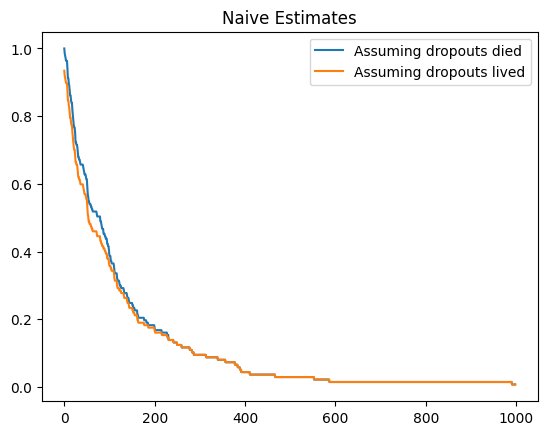

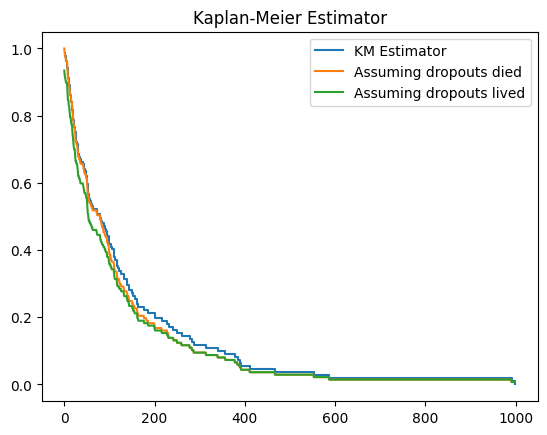

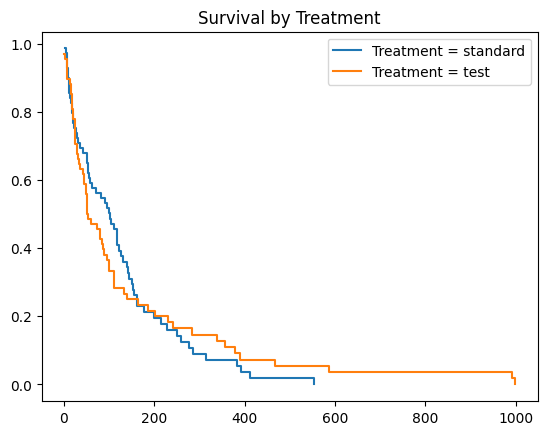

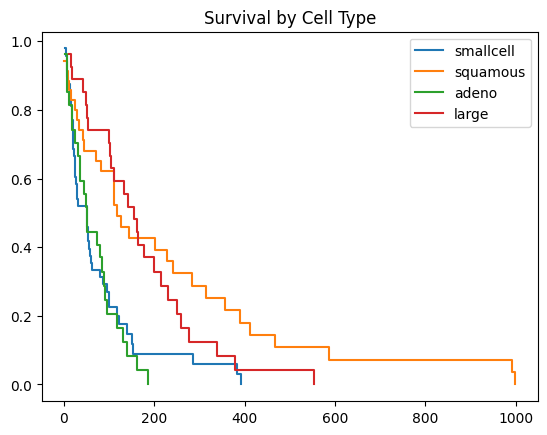

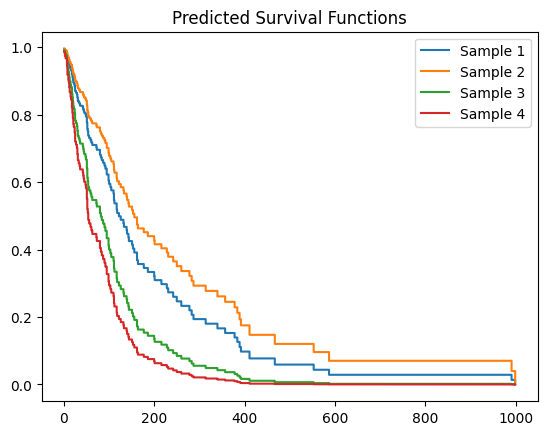

,Covariate,Log-Hazard Ratios,Concordance Index
0,Age_in_years,-0.008549,0.736256
1,Celltype=large,-0.788672,0.736256
2,Celltype=smallcell,-0.331813,0.736256
3,Celltype=squamous,-1.188299,0.736256
4,Karnofsky_score,-0.032622,0.736256
5,Months_from_Diagnosis,-0.000092,0.736256
6,Prior_therapy=yes,0.072327,0.736256
7,Treatment=test,0.289936,0.736256


In [4]:
# Complete end-to-end implementation for the given task

import numpy as np
import pandas as pd
from sksurv.datasets import load_veterans_lung_cancer
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sksurv.metrics import concordance_index_censored
import matplotlib.pyplot as plt

# Load and preprocess the data
x, y = load_veterans_lung_cancer()
y_array = np.array(y.tolist())

# Naive Estimates
Tmax1 = int(y_array[:, 1].max())
Tmax2 = int(y_array[y_array[:, 0] == 1][:, 1].max())

N = len(y_array)
S1 = [np.sum(y_array[:, 1] > t) / N for t in range(Tmax1)]
S2 = [np.sum(y_array[y_array[:, 0] == 1][:, 1] > t) / N for t in range(Tmax2)]

# Kaplan-Meier Estimator
time_km, survival_prob_km = kaplan_meier_estimator(y_array[:, 0].astype(bool), y_array[:, 1])

# Survival by Treatment
treatment_curves = {}
for treatment_type in ("standard", "test"):
    mask = x["Treatment"] == treatment_type
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        y_array[:, 0][mask].astype(bool), y_array[:, 1][mask]
    )
    treatment_curves[treatment_type] = (time_treatment, survival_prob_treatment)

# Survival by Cell Type
cell_curves = {}
for value in ("smallcell", "squamous", "adeno", "large"):
    mask = x["Celltype"] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(
        y_array[:, 0][mask].astype(bool), y_array[:, 1][mask]
    )
    cell_curves[value] = (time_cell, survival_prob_cell)

# Cox Proportional Hazards Model
x_encoded = OneHotEncoder().fit_transform(x)
cox_model = CoxPHSurvivalAnalysis()
cox_model.fit(x_encoded, y)
log_hazard_ratios = pd.Series(cox_model.coef_, index=x_encoded.columns)

# Predictions
x_new = pd.DataFrame.from_dict(
    {
        1: [65, 0, 0, 1, 60, 1, 0, 1],
        2: [65, 0, 0, 1, 60, 1, 0, 0],
        3: [65, 0, 1, 0, 60, 1, 0, 0],
        4: [65, 0, 1, 0, 60, 1, 0, 1],
    },
    columns=x_encoded.columns,
    orient="index",
)
pred_surv = cox_model.predict_survival_function(x_new)

# Evaluation
prediction = cox_model.predict(x_encoded)
concordance_index = concordance_index_censored(
    y["Status"], y["Survival_in_days"], prediction
)[0]

# Visualizations
# Naive Estimates Plot
plt.figure()
plt.plot(range(Tmax1), S1, label="Assuming dropouts died")
plt.plot(range(Tmax2), S2, label="Assuming dropouts lived")
plt.title("Naive Estimates")
plt.legend()
plt.show()

# Kaplan-Meier Curve
plt.figure()
plt.step(time_km, survival_prob_km, where="post", label="KM Estimator")
plt.plot(range(Tmax1), S1, label="Assuming dropouts died")
plt.plot(range(Tmax2), S2, label="Assuming dropouts lived")
plt.title("Kaplan-Meier Estimator")
plt.legend()
plt.show()

# Survival by Treatment
plt.figure()
for treatment_type, (time, survival_prob) in treatment_curves.items():
    plt.step(time, survival_prob, where="post", label=f"Treatment = {treatment_type}")
plt.title("Survival by Treatment")
plt.legend()
plt.show()

# Survival by Cell Type
plt.figure()
for cell_type, (time, survival_prob) in cell_curves.items():
    plt.step(time, survival_prob, where="post", label=f"{cell_type}")
plt.title("Survival by Cell Type")
plt.legend()
plt.show()

# Predictions Plot
plt.figure()
time_points = np.arange(1, 1000)
for i, surv_func in enumerate(pred_surv):
    plt.step(
        time_points, surv_func(time_points), where="post", label=f"Sample {i + 1}"
    )
plt.title("Predicted Survival Functions")
plt.legend()
plt.show()

# Results Summary
results_summary = pd.DataFrame({
    "Log-Hazard Ratios": log_hazard_ratios,
    "Concordance Index": [concordance_index] * len(log_hazard_ratios),
}).reset_index()
results_summary.columns = ["Covariate", "Log-Hazard Ratios", "Concordance Index"]

display(results_summary)
